# Periodic homogenization of linear elastic materials

## Introduction

This tour will show how to perform periodic homogenization of linear elastic materials. The considered 2D plane strain problem deals with a skewed unit cell of dimensions $1\times \sqrt{3}/2$ consisting of circular inclusions (numbered $1$) of radius $R$ with elastic properties $(E_r, \nu_r)$ and embedded in a matrix material (numbered $0$) of properties $(E_m, \nu_m)$ following an hexagonal pattern. A classical result of homogenization theory ensures that the resulting overall behavior will be isotropic, a property that will be numerically verified later.

In [1]:
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

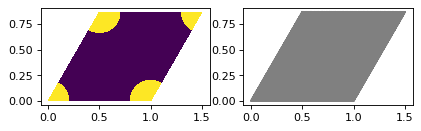

In [2]:
a = 1.         # unit cell width
b = sqrt(3.)/2. # unit cell height
c = 0.5        # horizontal offset of top boundary
R = 0.2        # inclusion radius
vol = a*b      # unit cell volume
# we define the unit cell vertices coordinates for later use
vertices = np.array([[0, 0.],
                     [a, 0.],
                     [a+c, b],
                     [c, b]])
fname = "hexag_incl"
mesh = Mesh(fname + ".xml")
subdomains = MeshFunction("size_t", mesh, fname + "_physical_region.xml")
facets = MeshFunction("size_t", mesh, fname + "_facet_region.xml")
plt.figure(dpi=80)
plt.subplot(1,2,1)
plot(subdomains)
plt.subplot(1,2,2)
plot(mesh)

**Remark**: `mshr` does not allow to generate a meshed domain with perfectly matching vertices on opposite boundaries as would be required when imposing periodic boundary conditions. For this reason, we used a `Gmsh`-generated mesh.

## Periodic homogenization framework

The goal of homogenization theory consists in computing the apparent elastic moduli of the homogenized medium associated with a given microstructure. In a linear elastic setting, this amounts to solving the following auxiliary problem defined on the unit cell $\mathcal{A}$:

$$\begin{equation}\begin{cases}\operatorname{div} \boldsymbol{\sigma} = \boldsymbol{0} & \text{in } \mathcal{A} \\ 
\boldsymbol{\sigma} = \mathbb{C}(\boldsymbol{y}):\boldsymbol{\varepsilon} & \text{for }\boldsymbol{y}\in\mathcal{A} \\
\boldsymbol{\varepsilon} = \boldsymbol{E} + \nabla^s \boldsymbol{v} & \text{in } \mathcal{A} \\
\boldsymbol{v} & \text{is } \mathcal{A}\text{-periodic} \\
\boldsymbol{T}=\boldsymbol{\sigma}\cdot\boldsymbol{n} & \text{is } \mathcal{A}\text{-antiperiodic}
\end{cases} \label{auxiliary-problem}
\end{equation}$$

where $\boldsymbol{E}$ is the **given** macroscopic strain, $\boldsymbol{v}$ a periodic fluctuation and $\mathbb{C}(\boldsymbol{y})$ is the heterogeneous elasticity tensor depending on the microscopic space variable $\boldsymbol{y}\in\mathcal{A}$. By construction, the local microscopic strain is equal on average to the macroscopic strain: $\langle \boldsymbol{\varepsilon} \rangle = \boldsymbol{E}$. Upon defining the macroscopic stress $\boldsymbol{\Sigma}$ as the microscopic stress average: $\langle \boldsymbol{\sigma} \rangle = \boldsymbol{\Sigma}$, there will be a linear relationship between the auxiliary problem loading parameters $\boldsymbol{E}$ and the resulting average stress:

$$\boldsymbol{\Sigma}  = \mathbb{C}^{hom}:\boldsymbol{E}$$

where $\mathbb{C}^{hom}$ represents the apparent elastic moduli of the homogenized medium. Hence, its components can be computed by solving elementary load cases corresponding to the different components of $\boldsymbol{E}$ and performing a unit cell average of the resulting microscopic stress components.

### Total displacement as the main unknown

The previous problem can also be reformulated by using the total displacement $\boldsymbol{u} = \boldsymbol{E}\cdot\boldsymbol{y} + \boldsymbol{v}$ as the main unknown with now $\boldsymbol{\varepsilon} = \nabla^s \boldsymbol{u}$. The periodicity condition is therefore equivalent to the following constraint: 

$$\boldsymbol{u}(\boldsymbol{y}^+)-\boldsymbol{u}(\boldsymbol{y}^-) = \boldsymbol{E}\cdot(\boldsymbol{y}^+-\boldsymbol{y}^-)$$

where $\boldsymbol{y}^{\pm}$ are opposite points on the unit cell boundary related by the periodicity condition. This formulation is widely used in solid mechanics FE software as it does not require specific change of the problem formulation but just adding tying constraints between some degrees of freedom.

This formulation is however not easy to translate in FEniCS. It would indeed require introducing Lagrange multipliers defined on some part of the border only, a feature which does not seem to be available at the moment.

### Periodic fluctuation as the main unknown

Instead, we will keep the initial formulation and consider the periodic fluctuation $\boldsymbol{v}$ as the main unknown. The periodicity constraint on $\boldsymbol{v}$ will be imposed in the definition of the associated FunctionSpace using the ``constrained_domain`` optional keyword. To do so, one must define the periodic map linking the different unit cell boundaries. Here the unit cell is 2D and its boundary is represented by a parallelogram of vertices ``vertices`` and the corresponding base vectors `a1` and `a2` are computed. The right part is then mapped onto the left part, the top part onto the bottom part and the top-right corner onto the bottom-left one.

In [3]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    def __init__(self, vertices, tolerance=DOLFIN_EPS):
        """ vertices stores the coordinates of the 4 unit cell corners"""
        SubDomain.__init__(self, tolerance)
        self.tol = tolerance
        self.vv = vertices
        self.a1 = self.vv[1,:]-self.vv[0,:] # first vector generating periodicity
        self.a2 = self.vv[3,:]-self.vv[0,:] # second vector generating periodicity
        # check if UC vertices form indeed a parallelogram
        assert np.linalg.norm(self.vv[2, :]-self.vv[3, :] - self.a1) <= self.tol
        assert np.linalg.norm(self.vv[2, :]-self.vv[1, :] - self.a2) <= self.tol
        
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the 
        # bottom-right or top-left vertices
        return bool((near(x[0], self.vv[0,0] + x[1]*self.a2[0]/self.vv[3,1], self.tol) or 
                     near(x[1], self.vv[0,1] + x[0]*self.a1[1]/self.vv[1,0], self.tol)) and 
                     (not ((near(x[0], self.vv[1,0], self.tol) and near(x[1], self.vv[1,1], self.tol)) or 
                     (near(x[0], self.vv[3,0], self.tol) and near(x[1], self.vv[3,1], self.tol)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], self.vv[2,0], self.tol) and near(x[1], self.vv[2,1], self.tol): # if on top-right corner
            y[0] = x[0] - (self.a1[0]+self.a2[0])
            y[1] = x[1] - (self.a1[1]+self.a2[1])
        elif near(x[0], self.vv[1,0] + x[1]*self.a2[0]/self.vv[2,1], self.tol): # if on right boundary
            y[0] = x[0] - self.a1[0]
            y[1] = x[1] - self.a1[1]
        else:   # should be on top boundary
            y[0] = x[0] - self.a2[0]
            y[1] = x[1] - self.a2[1]

We now define the constitutive law for both phases:

In [4]:
Em = 50e3
num = 0.2
Er = 210e3
nur = 0.3
material_parameters = [(Em, num), (Er, nur)]
nphases = len(material_parameters)
def eps(v):
    return sym(grad(v))
def sigma(v, i, Eps):
    E, nu = material_parameters[i]
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    return lmbda*tr(eps(v) + Eps)*Identity(2) + 2*mu*(eps(v)+Eps)

## Variational formulation

The previous problem is very similar to a standard linear elasticity problem, except for the periodicity constraint which has now been included in the FunctionSpace definition and for the presence of an eigenstrain term $\boldsymbol{E}$. It can easily be shown that the variational formulation of the previous problem reads as: Find $\boldsymbol{v}\in V$ such that:

$$\begin{equation}
F(\boldsymbol{v},\widehat{\boldsymbol{v}}) = \int_{\mathcal{A}} (\boldsymbol{E}+\nabla^s\boldsymbol{v}):\mathbb{C}(\boldsymbol{y}):\nabla^s\widehat{\boldsymbol{v}}\text{ d} \Omega = 0 \quad \forall \widehat{\boldsymbol{v}}\in V
\end{equation}$$

The above problem is not well-posed because of the existence of rigid body translations. One way to circumvent this issue would be to fix one point but instead we will add an additional constraint of zero-average of the fluctuation field $v$ as is classically done in homogenization theory. This is done by considering an additional vectorial Lagrange multiplier $\lambda$ and considering the following variational problem (see the [pure Neumann boundary conditions FEniCS demo](https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/neumann-poisson/demo_neumann-poisson.py.html) for a similar formulation): Find $(\boldsymbol{v},\boldsymbol{\lambda})\in V\times \mathbb{R}^2$ such that:

$$\begin{equation}
\int_{\mathcal{A}} (\boldsymbol{E}+\nabla^s\boldsymbol{v}):\mathbb{C}(\boldsymbol{y}):\nabla^s\widehat{\boldsymbol{v}}\text{ d} \Omega + \int_{\mathcal{A}} \boldsymbol{\lambda}\cdot\widehat{\boldsymbol{v}} \text{ d} \Omega + \int_{\mathcal{A}} \widehat{\boldsymbol{\lambda}}\cdot\boldsymbol{v} \text{ d} \Omega = 0 \quad \forall (\widehat{\boldsymbol{v}}, \widehat{\boldsymbol{\lambda}})\in V\times\mathbb{R}^2
\end{equation}$$

Which can be summarized as:

$$\begin{equation}
a(\boldsymbol{v},\widehat{\boldsymbol{v}}) + b(\boldsymbol{\lambda},\widehat{\boldsymbol{v}}) + b(\widehat{\boldsymbol{\lambda}}, \boldsymbol{v}) = L(\widehat{\boldsymbol{v}}) \quad \forall (\widehat{\boldsymbol{v}}, \widehat{\boldsymbol{\lambda}})\in V\times\mathbb{R}^2
\end{equation}$$

This readily translates into the following FEniCS code:

In [8]:
Ve = VectorElement("CG", mesh.ufl_cell(), 2)
Re = VectorElement("R", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([Ve, Re]), constrained_domain=PeriodicBoundary(vertices, tolerance=1e-10))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
w = Function(W)
dx = Measure('dx')(subdomain_data=subdomains)

Eps = Constant(((0, 0), (0, 0)))
F = sum([inner(sigma(dv, i, Eps), eps(v_))*dx(i) for i in range(nphases)])
a, L = lhs(F), rhs(F)
a += dot(lamb_,dv)*dx + dot(dlamb,v_)*dx

We have used a general implementation using a sum over the different phases for the functional `F`. We then used the `lhs` and `rhs` functions to respectively extract the corresponding bilinear $a$ and linear $L$ forms.

## Resolution

The resolution of the auxiliary problem is performed for elementary load cases consisting of uniaxial strain and pure shear sollicitations by assigning unit values of the correspnonding $E_{ij}$ components. For each load case, the average stress $\boldsymbol{\Sigma}$ is computed components by components and the macroscopic stiffness components $\mathbb{C}^{hom}$ are then printed.

In [9]:
def macro_strain(i):
    """returns the macroscopic strain for the 3 elementary load cases"""
    Eps_Voigt = np.zeros((3,))
    Eps_Voigt[i] = 1
    return np.array([[Eps_Voigt[0], Eps_Voigt[2]/2.], 
                    [Eps_Voigt[2]/2., Eps_Voigt[1]]])
def stress2Voigt(s):
    return as_vector([s[0,0], s[1,1], s[0,1]])

Chom = np.zeros((3, 3))
for (j, case) in enumerate(["Exx", "Eyy", "Exy"]):
    print("Solving {} case...".format(case))
    Eps.assign(Constant(macro_strain(j)))
    F = sum([inner(sigma(dv, i, Constant(macro_strain(j))), eps(v_))*dx(i) for i in range(nphases)]) + dot(lamb_,dv)*dx + dot(dlamb,v_)*dx
    a, L = lhs(F), rhs(F)
    solve(a == L, w, [])
    (v, lamb) = split(w)
    Sigma = np.zeros((3,))
    for k in range(3):
        Sigma[k] = assemble(sum([stress2Voigt(sigma(v, i, Eps))[k]*dx(i) for i in range(nphases)]))/vol
    Chom[j, :] = Sigma

print(np.array_str(Chom, precision=2))

Solving Exx case...
Solving Eyy case...
Solving Exy case...
[[ 6.56e+04  1.74e+04 -2.43e-02]
 [ 1.74e+04  6.56e+04 -4.10e-02]
 [-2.43e-02 -4.10e-02  2.41e+04]]


In [ ]:
for (j, case) in enumerate(["Exx", "Eyy", "Exy"]):
    print("Solving {} case...".format(case))
    print(j)

It can first be verified that the obtained macroscopic stiffness is indeed symmetric and that the corresponding behaviour is quasi-isotropic (up to the finite element discretization error). Indeed, if $\lambda^{hom} = \mathbb{C}_{xxyy}$ and $\mu^{hom} = \mathbb{C}_{xyxy}$ we have that $\mathbb{C}_{xxxx}\approx\mathbb{C}_{yyyy}\approx \mathbb{C}_{xxyy}+2\mathbb{C}_{xyxy} = \lambda^{hom}+2\mu^{hom}$.

> **Note:** The macroscopic stiffness is not exactly symmetric because we computed it from the average stress which is not stricly verifying local equilibrium on the unit cell due to the FE discretization. A truly symmetric version can be obtained from the computation of the bilinear form for a pair of solutions to the elementary load cases.

In [ ]:
lmbda_hom = Chom[0, 1]
mu_hom = Chom[2, 2]
print(Chom[0, 0], lmbda_hom + 2*mu_hom)

We thus deduce that $E^{hom} = \mu^{hom}\dfrac{3\lambda^{hom}+2\mu^{hom}}{\lambda^{hom}+\mu^{hom}}$ and $\nu^{hom} = \dfrac{\lambda^{hom}}{2(\lambda^{hom}+\mu^{hom})}$ that is:

In [ ]:
E_hom = mu_hom*(3*lmbda_hom + 2*mu_hom)/(lmbda_hom + mu_hom)
nu_hom = lmbda_hom/(lmbda_hom + mu_hom)/2
print("Apparent Young modulus:", E_hom)
print("Apparent Poisson ratio:", nu_hom)

In [ ]:
# plotting deformed unit cell with total displacement u = Eps*y + v
y = SpatialCoordinate(mesh)
plt.figure()
p = plot(0.5*(dot(Eps, y)+v), mode="displacement", title=case)
plt.colorbar(p)
plt.show()